## Goal: Which long SIRVs do we detect? What does their coverage look like over the length of their bodies?

In [126]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [127]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            strip_text_x=element_text(size=base_size + 1.5, family='Helvetica'),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [128]:
config = load_config()
od = '../'
meta_df = load_meta()
meta_df['lab_sample'] = meta_df['lab_number_sample'].astype(str)+'_'+\
                        meta_df['lab_sampleid']+'_'+\
                        meta_df['cell_line_id']


def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [129]:
init_plot_settings()
pop_c_dict, pop_order = get_population_colors()

## Ground truth -- the sirv / ercc gtf

In [130]:
gtf_df = pr.read_gtf('../data/qc_sirvs/SIRV_ERCC_longSIRV_multi-fasta_20210507.gtf').df

temp = gtf_df.loc[gtf_df.Chromosome.isin(spliced_sirvs)]
n_spliced_sirvs_tot = len(temp.transcript_id.unique())

# there are 69 spliced sirvs as ground truth

# get the transcript length of each sirv transcript
gtf_df['exon_len'] = gtf_df['End'] - gtf_df['Start']
gtf_df['transcript_len'] = gtf_df.groupby('transcript_id')['exon_len'].transform('sum')

gtf_df['mean_transcript_len'] = gtf_df.groupby('gene_id')['transcript_len'].transform('mean')
gtf_df['med_transcript_len'] = gtf_df.groupby('gene_id')['transcript_len'].transform('median')

# also get number of exons
gtf_df['n_exons'] = gtf_df.groupby('transcript_id')['exon_assignment'].transform('count')
gtf_df['mean_n_exons'] = gtf_df.groupby('gene_id')['n_exons'].transform('mean')
gtf_df['med_n_exons'] = gtf_df.groupby('gene_id')['n_exons'].transform('median')

# also get number of transcripts
gtf_df['n_transcripts'] = gtf_df.groupby('gene_id')['transcript_id'].transform('nunique')

# get # monoexonic transcripts
temp = gtf_df[['gene_id', 'transcript_id', 'n_exons']].groupby(['gene_id', 'n_exons']).nunique().reset_index()
temp = temp.loc[temp.n_exons==1]
temp.drop('n_exons', axis=1, inplace=True)
temp.rename({'transcript_id': 'n_monoexonic_transcripts'}, axis=1, inplace=True)
temp.loc[temp.gene_id=='SIRV6']
gtf_df = gtf_df.merge(temp,
                      how='left',
                      on='gene_id')

# sort the long sirvs at least by length
sirv_order = ['1', '2', '3', '4', '5', '6', '7',
              '4001', '4002', '4003',
              '6001', '6002', '6003', 
              '8001', '8002', '8003',
              '10001', '10002', '10003',
              '12001', '12002', '12003']
sirv_order = [f'SIRV{s}' for s in sirv_order]

# label sirv type
long_sirvs = ['4001', '4002', '4003',
              '6001', '6002', '6003', 
              '8001', '8002', '8003',
              '10001', '10002', '10003',
              '12001', '12002', '12003']
long_sirvs = [f'SIRV{s}' for s in long_sirvs]
gtf_df['sirv_type'] = np.nan
gtf_df.loc[gtf_df.Chromosome.isin(long_sirvs), 'sirv_type'] = 'long_sirv'

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_77584/3801397295.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'long_sirv' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


## We have to use the bam to bed representation

In [131]:
f = proc_cfg(expand(config['lr']['qc_sirvs']['bed_summary'],
                    annot_completeness='C')[0], od)
df = pr.read_bed(f).df
df.rename({'ThickStart': 'lab_sample'}, axis=1, inplace=True)


In [132]:
# limit to the long sirvs
df = df.loc[df.Chromosome.isin(long_sirvs)]
df.Chromosome.unique()

['SIRV4001', 'SIRV4002', 'SIRV4003', 'SIRV6001', 'SIRV6002', ..., 'SIRV10002', 'SIRV10003', 'SIRV12001', 'SIRV12002', 'SIRV12003']
Length: 15
Categories (93, object): ['ERCC-00002', 'ERCC-00003', 'ERCC-00004', 'ERCC-00009', ..., 'SIRV7', 'SIRV8001', 'SIRV8002', 'SIRV8003']

In [133]:
df.loc[df.Name.duplicated(keep=False)].sort_values(by='Name').head()


,Chromosome,Start,End,Name,Score,Strand,lab_sample


In [149]:
cov_data = []
cov_df = pd.DataFrame()

# Iterate over each row to compute coverage
for chrom in df.Chromosome.unique():
    chrom_df = df.loc[df.Chromosome==chrom]
    for _, row in chrom_df.iterrows():
        positions = range(row['Start'], row['End'])
        cov_data.extend(positions)

    # for each chromosome make this groupby'd dataframe w/ 
    # counts @ each position
    temp = pd.Series(cov_data).value_counts().sort_index().reset_index()
    temp.columns = ['pos', 'cov']
    temp['chrom'] = chrom

    # append to whole df
    cov_df = pd.concat([cov_df, temp], axis=0)

# get length bin of each sirv
cov_df['len_bin'] = np.nan
len_bins = [4,6,8,10,12]
len_bin_order = []
for l in len_bins:
    len_bin = f'{l}kb'
    cov_df.loc[cov_df.chrom.str.contains(f'SIRV{l}'), 'len_bin'] = len_bin
    len_bin_order.append(len_bin)

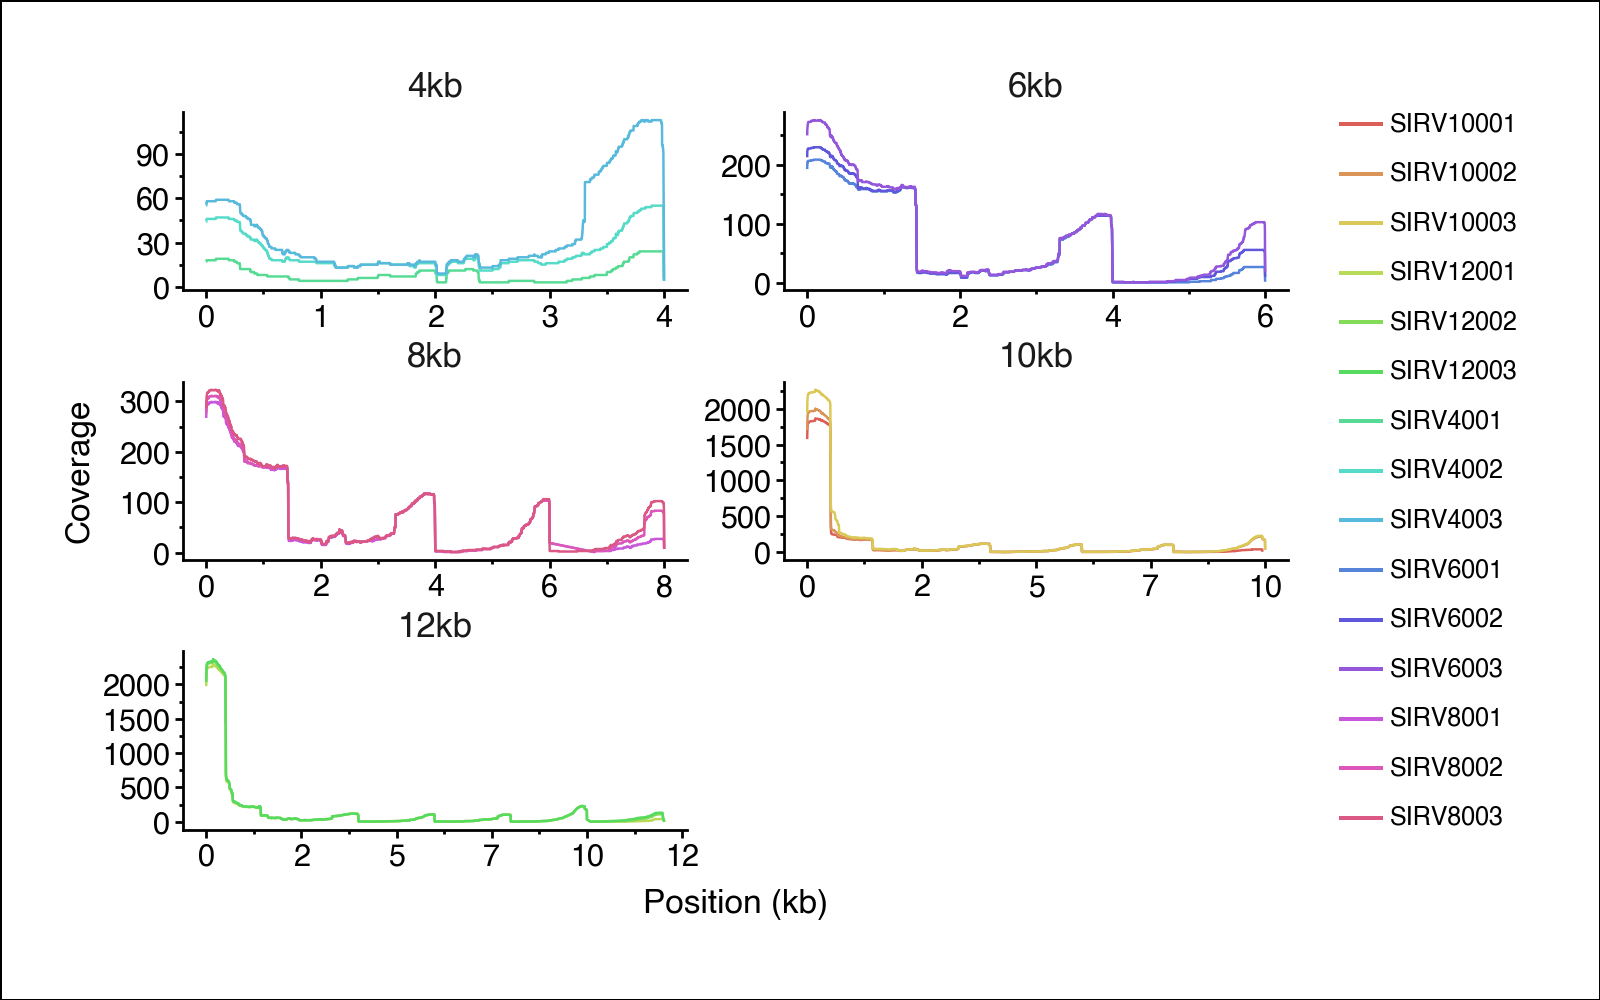

In [156]:
cov_df['len_bin'] = pd.Categorical(cov_df['len_bin'], categories=len_bin_order, ordered=True)

p = (
    ggplot(cov_df, aes(x='pos', y='cov', color='chrom'))
    + geom_line()
    # + geom_smooth(span=0.1, se=False)
    # + geom_histogram(binwidth=10, position='identity', alpha=0.6, color='black')
    + facet_wrap('~len_bin', ncol=2, scales='free')
    + scale_x_continuous(labels=lambda l: [int(x/1000) for x in l])
    + my_theme(w=8, h=5)
    + labs(title='', x='Position (kb)', y='Coverage')
)

p.show()

In [152]:
# gtf_df.loc[gtf_df.sirv_type=='long_sirv'][['Chromosome', 'Strand']].drop_duplicates()

## older

In [101]:
# only long sirvs
temp = df.loc[df.spike_type_2 == 'long_sirv']

AttributeError: 'DataFrame' object has no attribute 'spike_type_2'

In [31]:
temp[['isoform', 'chrom', 'length', 'diff_to_TSS', 'diff_to_TTS', 'diff_to_gene_TSS', 'diff_to_gene_TTS']].head()

,isoform,chrom,length,diff_to_TSS,diff_to_TTS,diff_to_gene_TSS,diff_to_gene_TTS
6856,35faaefb-8556-4c08-b4b3-8d463acf06a2:0,SIRV6001,1432,NaN,NaN,NaN,NaN
6857,1597fa08-13f5-44fc-9a3e-8bc84b42fa35:0,SIRV6001,332,NaN,NaN,NaN,NaN
6858,25104590-1987-48b6-8536-eedd2e8e5806:0,SIRV6001,1419,NaN,NaN,NaN,NaN
6859,a20319a3-52b2-4e33-acac-fc831726eb12:0,SIRV6001,537,NaN,NaN,NaN,NaN
6860,d97178f7-ef5d-420a-8b43-fc37e9cdcb7d:0,SIRV6001,857,-5141.0,-2.0,-5141.0,-2.0


In [25]:
gtf_df.tail()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,transcript_id,...,exon_assignment,exon_len,transcript_len,mean_transcript_len,med_transcript_len,n_exons,mean_n_exons,med_n_exons,n_transcripts,n_monoexonic_transcripts
459,SIRV10002,LexogenSIRVData,exon,0,10001,.,+,0,SIRV10002,SIRV10002,...,SIRV10002_0,10001,10001,10001.0,10001.0,1,1.0,1.0,1,1.0
460,SIRV10003,LexogenSIRVData,exon,0,9970,.,+,0,SIRV10003,SIRV10003,...,SIRV10003_0,9970,9970,9970.0,9970.0,1,1.0,1.0,1,1.0
461,SIRV12001,LexogenSIRVData,exon,0,12029,.,+,0,SIRV12001,SIRV12001,...,SIRV12001_0,12029,12029,12029.0,12029.0,1,1.0,1.0,1,1.0
462,SIRV12002,LexogenSIRVData,exon,0,11999,.,+,0,SIRV12002,SIRV12002,...,SIRV12002_0,11999,11999,11999.0,11999.0,1,1.0,1.0,1,1.0
463,SIRV12003,LexogenSIRVData,exon,0,12000,.,+,0,SIRV12003,SIRV12003,...,SIRV12003_0,12000,12000,12000.0,12000.0,1,1.0,1.0,1,1.0
